In [1]:
import torch
import torch.nn as nn
from torchvision.models import resnet18,resnet50
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils import data
import numpy as np
import matplotlib.pyplot as plt
import cv2

from src.data_loader import ClassificationDataset,SingleSlideClassificationDataset
from src.transforms import ToTensor
from albumentations import (
    RandomRotate90,
    Flip,
    Transpose,
    RandomBrightnessContrast,Normalize ,
)
from torchvision.transforms.functional import to_pil_image
import timm
 

/data/apps/conda/mehdi/envs/classif/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Model redefinition to extract the gradients

In [2]:
from src.models import build_model

class ResNet(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(ResNet, self).__init__()

        # define the resnet152
        self.resnet = timm.create_model("resnet18", pretrained=pretrained)
        infeat = 512  # self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(infeat, num_classes)  # make the change

        # isolate the feature blocks

        self.conv1 = (self.resnet.conv1)
        self.bn1 = (self.resnet.bn1)
        self.act1 = (nn.ReLU(inplace=True))
        self.maxpool = nn.MaxPool2d(
            kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False
        )

        self.layer1 = self.resnet.layer1
        self.layer2 = self.resnet.layer2
        self.layer3 = self.resnet.layer3
        self.layer4 = self.resnet.layer4

        # average pooling layer
        self.global_pool = self.resnet.global_pool

        # classifier
        self.fc = nn.Linear(infeat, num_classes)

        # gradient placeholder
        self.gradient = None

    # hook for the gradients
    def activations_hook(self, grad):
        self.gradient = grad

    def get_gradient(self):
        return self.gradient

    def get_activations(self, x):
        return self.forward_conv(x)

    def forward_conv(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

    def forward(self, x):

        # extract the features
        x = self.forward_conv(x)

        # register the hook
        h = x.register_hook(self.activations_hook)

        # complete the forward pass
        x = self.global_pool(x)

        x = self.fc(x)

        return x


######################################################
def dropout_linear_relu(dim_in, dim_out, p_drop):
    return [nn.Dropout(p_drop), nn.Linear(dim_in, dim_out), nn.ReLU(inplace=True)]


def conv_relu_maxp(in_channels, out_channels, ks):
    return [
        nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=ks,
            stride=1,
            padding=int((ks - 1) / 2),
            bias=True,
        ),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2),
    ]
class VanillaCNN(nn.Module):
    def __init__(self, num_classes=1):
        super(VanillaCNN, self).__init__()

        # By default, Linear layers and Conv layers use Kaiming He initialization

        self.features = nn.Sequential(
            *conv_relu_maxp(3, 16, 5),
            *conv_relu_maxp(16, 32, 5),
            *conv_relu_maxp(32, 64, 5),
        )
        probe_tensor = torch.zeros((1, 3, 1024, 1024))
        out_features = self.features(probe_tensor).view(-1)

        self.classifier = nn.Sequential(
            *dropout_linear_relu(out_features.shape[0], 128, 0.5),
            *dropout_linear_relu(128, 256, 0.5),
            nn.Linear(256, num_classes),
        )
        self.gradient = None
    
    # hook for the gradients
    def activations_hook(self, grad):
        self.gradient = grad
    
    def get_gradient(self):
        return self.gradient
    
    def get_activations(self, x):
        return self.features(x)
    def forward(self, x):
        x = self.features(x)
        # register the hook
        h = x.register_hook(self.activations_hook)
        x = x.view(x.size()[0], -1)  #  OR  x = x.view(-1, self.num_features)
        y = self.classifier(x)
        y = torch.sigmoid(y)
        return y



## Load the model 

In [3]:
# name  = "/data/DeepLearning/mehdi/log/luminal/resnet_85/luminal/2a71a50204c84260936997a0cef2cd27/checkpoints/epoch=16-val_loss_bce=0.000.ckpt"
# name  = "/data/DeepLearning/mehdi/log/luminal/resnet_85/luminal/2a71a50204c84260936997a0cef2cd27/checkpoints/epoch=16-val_loss_bce=0.000.ckpt"
name  = "/data/DeepLearning/mehdi/log/luminal/resnet_145/luminal/b8f8b937e8a74156840152cbd38cc402/checkpoints/epoch=15-val_loss_bce=0.000.ckpt"
name  = "/data/DeepLearning/mehdi/log/luminal/resnet_145/luminal/b8f8b937e8a74156840152cbd38cc402/checkpoints/epoch=15-val_loss_bce=0.000.ckpt"
name  = "/data/DeepLearning/mehdi/log/luminal/resnet_159/luminal/324ca250a42945b8870334e04b1c7483/checkpoints/epoch=4-val_loss_bce=0.000.ckpt"
name  = "/data/DeepLearning/mehdi/log/luminal/resnet_84/luminal/0f86cca6485e475dbf1c9fa736074684/checkpoints/last.ckpt"
name  = "/data/DeepLearning/mehdi/log/luminal/resnet_159/luminal/324ca250a42945b8870334e04b1c7483/checkpoints/last.ckpt"
name = "/data/DeepLearning/mehdi/log/luminal/resnet_224/luminal/90a1604aa3624a7c949c9ae3766b8c23/checkpoints/epoch=14-val_loss_ce=0.000.ckpt"

lesnet = torch.load(name)

resnet = {k.replace("model.",""):v for k,v in lesnet["state_dict"].items()} 
resnet_ = {k.replace("model.","resnet."):v for k,v in lesnet["state_dict"].items()} 



In [4]:
sttdict = {**resnet, **resnet_}

In [5]:
# create the "blank" networks like they
# were created in the Lightning Module

name  = "/data/DeepLearning/mehdi/log/luminal/resnet_145/luminal/b8f8b937e8a74156840152cbd38cc402/checkpoints/epoch=15-val_loss_bce=0.000.ckpt"
name  = "/data/DeepLearning/mehdi/log/luminal/resnet_159/luminal/324ca250a42945b8870334e04b1c7483/checkpoints/epoch=4-val_loss_bce=0.000.ckpt"
# resnet = torch.load(name)

model = build_model("resnet",3)
model = ResNet(3)

# Load the models for inference
model.load_state_dict(
    sttdict,strict=True
)
_ = model.eval()


In [6]:
cnt = 0
#0 3 211

In [7]:
max = 0

In [6]:

name = "/data/DeepLearning/mehdi/log/luminal/resnet_85/16/0/BB luminal B classe comme B| prediction:0.740234375.png"
name = "/data/DeepLearning/mehdi/log/luminal/resnet_85/16/0/BB luminal B classe comme B| prediction:0.7939453125.png"
name = "/data/DeepLearning/mehdi/log/luminal/resnet_85/16/1/AB luminal A classe comme B| prediction:0.7822265625.png"
name = "/data/DeepLearning/mehdi/log/luminal/resnet_85/16/1/AB luminal A classe comme B| prediction:0.79833984375.png"
name = "/data/DeepLearning/mehdi/log/luminal/resnet_85/16/1/AB luminal A classe comme B| prediction:0.76025390625.png"
name = "/data/DeepLearning/mehdi/log/luminal/resnet_85/16/1/AA luminal A classe comme A| prediction:0.1959228515625.png"
name = "/data/DeepLearning/mehdi/log/luminal/resnet_85/16/2/BB luminal B classe comme B| prediction:0.7431640625.png"
name = "/data/DeepLearning/mehdi/log/luminal/resnet_85/16/0/BB luminal B classe comme B| prediction:0.77734375.png"
name = "/data/DeepLearning/mehdi/log/luminal/resnet_145/15/0/BA luminal B classe comme A| prediction:0.0703125.png"

In [7]:
names = ["/data/DeepLearning/mehdi/log/luminal/resnet_85/16/0/BB luminal B classe comme B| prediction:0.77734375.png"
,
 "/data/DeepLearning/mehdi/log/luminal/resnet_85/16/0/BB luminal B classe comme B| prediction:0.740234375.png",
 "/data/DeepLearning/mehdi/log/luminal/resnet_85/16/0/BB luminal B classe comme B| prediction:0.7939453125.png",
 "/data/DeepLearning/mehdi/log/luminal/resnet_85/16/1/AB luminal A classe comme B| prediction:0.7822265625.png",
 "/data/DeepLearning/mehdi/log/luminal/resnet_85/16/1/AB luminal A classe comme B| prediction:0.79833984375.png",
 "/data/DeepLearning/mehdi/log/luminal/resnet_85/16/2/BB luminal B classe comme B| prediction:0.7431640625.png",
 "/data/DeepLearning/mehdi/log/luminal/resnet_85/16/1/AB luminal A classe comme B| prediction:0.76025390625.png",
 "/data/DeepLearning/mehdi/log/luminal/resnet_85/16/1/AA luminal A classe comme A| prediction:0.1959228515625.png",]

True
tensor([  1.6096,   0.9695, -30.6738], device='cuda:0',
       grad_fn=<UnbindBackward0>)
True
tensor([  0.4241,   1.8424, -29.9916], device='cuda:0',
       grad_fn=<UnbindBackward0>)
True
tensor([  0.7685,   1.2808, -25.2539], device='cuda:0',
       grad_fn=<UnbindBackward0>)
True
tensor([  3.0317,  -0.1362, -38.0452], device='cuda:0',
       grad_fn=<UnbindBackward0>)
True
tensor([  1.6332,   1.3296, -37.7206], device='cuda:0',
       grad_fn=<UnbindBackward0>)
True
tensor([ 20.6824, -13.3119, -73.8506], device='cuda:0',
       grad_fn=<UnbindBackward0>)
True
tensor([  3.6469,  -1.0795, -32.0897], device='cuda:0',
       grad_fn=<UnbindBackward0>)
True
tensor([  1.6697,   0.6199, -29.3380], device='cuda:0',
       grad_fn=<UnbindBackward0>)


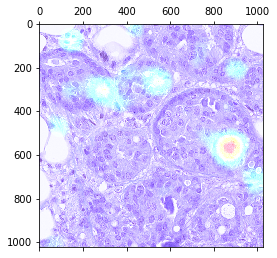

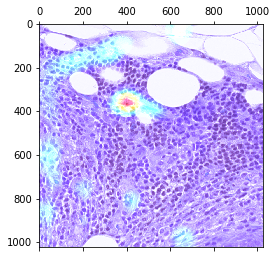

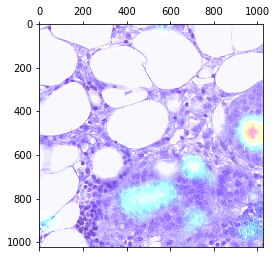

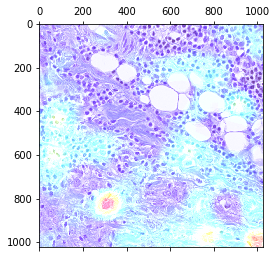

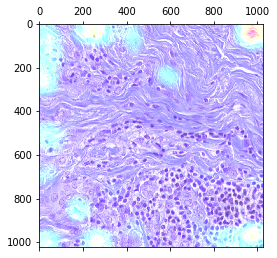

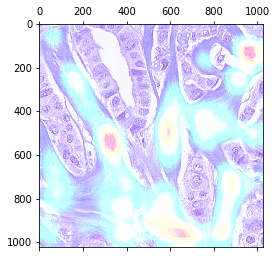

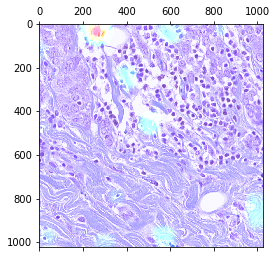

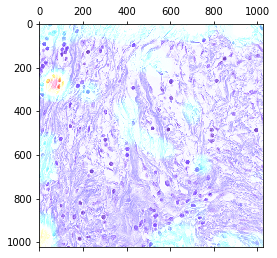

In [12]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
 
target_layers = [model.layer4[-1]]
# data_ = next(iter(dataloader))
for j,name in enumerate(names):
    image = cv2.imread(name)
    
    # Define a transform to convert PIL 
    # image to a Torch tensor
    transform = transforms.Compose([
        ToTensor()
    ])
    
    # transform = transforms.PILToTensor()
    # Convert the PIL image to Torch tensor
    img_tensor = ToTensor()(image=image)
    img= img_tensor["image"].unsqueeze(0)

    input_tensor = img#data_["image"] # Create an input tensor image for your model..
    # Note: input_tensor can be a batch tensor with several images!

    # Construct the CAM object once, and then re-use it on many images:
    cam = GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=True)

    # You can also use it within a with statement, to make sure it is freed,
    # In case you need to re-create it inside an outer loop:
    # with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
    #   ...

    # We have to specify the target we want to generate
    # the Class Activation Maps for.
    # If targets is None, the highest scoring category
    # will be used for every image in the batch.
    # Here we use ClassifierOutputTarget, but you can define your own custom targets
    # That are, for example, combinations of categories, or specific outputs in a non standard model.
    targeto = torch.tensor( [1.0])
    targeto.requires_grad = True
    print(targeto.requires_grad)
    for x in range(3):
        targets =  [
            ClassifierOutputTarget( 0 )
        ]


        # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

        # In this example grayscale_cam has only one image in the batch:
        grayscale_cam = grayscale_cam[0, :]
        rgb_img = to_pil_image(input_tensor.squeeze()/255)
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
        img1 = visualization
        img2 = np.array(to_pil_image(input_tensor.squeeze()))
        dst = cv2.addWeighted(img1, 1.2, img2, 1, 0)

        plt.matshow( dst)
        cv2.imwrite(f'/home/mehdi/code/luminal/data/map_{j}_label_{x}.jpg', dst)
        cv2.imwrite(f'/home/mehdi/code/luminal/data/map_he_{j}.jpg', np.array(img))
    

<Figure size 1080x720 with 0 Axes>

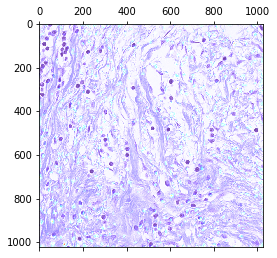

In [34]:
plt.figure(figsize=(15,10))
plt.matshow( dst)

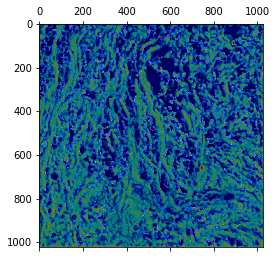

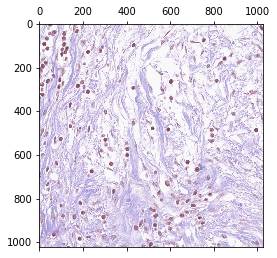

In [37]:
plt.matshow( visualization)
plt.matshow(to_pil_image(input_tensor.squeeze()))

In [123]:
from PIL import Image
for j,name in enumerate(names):
    image = cv2.imread(name)
    
    # Define a transform to convert PIL 
    # image to a Torch tensor
    transform = transforms.Compose([
        ToTensor()
    ])
    
    # transform = transforms.PILToTensor()
    # Convert the PIL image to Torch tensor
    img_tensor = ToTensor()(image=image)
    img= img_tensor["image"].unsqueeze(0)
    # get the gradient of the output with respect to the parameters of the model

    # _data = next(iter(dataloader))
    # img = dataset[45]["image"].unsqueeze(0).float()
    # forward pass
    # img = img_tensor.unsqueeze(0).float()
    pred = model(img.float())

    # prints tensor([2])
    print(torch.sigmoid(pred))
    pred[:].backward()

    # pull the gradients out of the model
    gradients = model.get_gradient()

    # pool the gradients across the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # get the activations of the last convolutional layer
    activations = model.get_activations(img).detach()

    print(activations.shape,pooled_gradients.shape)

    # weight the channels by corresponding gradients
    for i in range(64): #512
        activations[:, i, :, :] *= pooled_gradients[i]
        
    # average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze()

    # relu on top of the heatmap
    # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
    heatmap = np.maximum(heatmap, 0)

    # normalize the heatmap
    heatmap /= torch.max(heatmap)

    # draw the heatmap
    # plt.matshow(heatmap.squeeze())

    # make the heatmap to be a numpy array
    heatmap = heatmap.numpy()

    # interpolate the heatmap
    heatmap = cv2.resize(heatmap, (img.shape[2], img.shape[3]))
    img = to_pil_image(img.squeeze())
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    alpha = .5
    superimposed_img = cv2.addWeighted(np.array(img), alpha, heatmap, 1 - alpha, 0)# img  +heatmap*0.4
    # cv2.imwrite(f'./map_{cnt}.jpg', superimposed_img)
    cv2.imwrite(f'/home/mehdi/code/luminal/data/map_{j}_label_{x}.jpg', superimposed_img)
    cv2.imwrite(f'/home/mehdi/code/luminal/data/map_he_{j}.jpg', np.array(img))
    # plt.matshow(superimposed_img)
    cnt +=1
    superimposed_img.shape 
# tensor([[0.6008]], grad_fn=<SigmoidBackward0>)


tensor([[0.]], grad_fn=<SigmoidBackward0>)
torch.Size([1, 512, 32, 32]) torch.Size([512])
tensor([[0.]], grad_fn=<SigmoidBackward0>)
torch.Size([1, 512, 32, 32]) torch.Size([512])
tensor([[0.]], grad_fn=<SigmoidBackward0>)
torch.Size([1, 512, 32, 32]) torch.Size([512])
tensor([[0.]], grad_fn=<SigmoidBackward0>)
torch.Size([1, 512, 32, 32]) torch.Size([512])
tensor([[0.]], grad_fn=<SigmoidBackward0>)
torch.Size([1, 512, 32, 32]) torch.Size([512])
tensor([[0.]], grad_fn=<SigmoidBackward0>)
torch.Size([1, 512, 32, 32]) torch.Size([512])
tensor([[0.]], grad_fn=<SigmoidBackward0>)
torch.Size([1, 512, 32, 32]) torch.Size([512])
tensor([[2.7688e-28]], grad_fn=<SigmoidBackward0>)
torch.Size([1, 512, 32, 32]) torch.Size([512])


In [ ]:
img = img_tensor["image"].unsqueeze(0).shape

In [ ]:
img= img_tensor["image"].unsqueeze(0)

tensor([[-0.2258]], grad_fn=<AddmmBackward0>)
tensor([[0.4438]], grad_fn=<SigmoidBackward0>)
torch.Size([1, 512, 32, 32]) torch.Size([512])


(1024, 1024, 3)

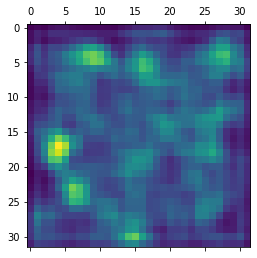

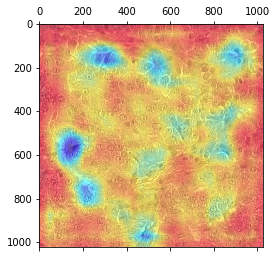

In [ ]:
# get the gradient of the output with respect to the parameters of the model

# _data = next(iter(dataloader))
# img = dataset[45]["image"].unsqueeze(0).float()
# forward pass
# img = img_tensor.unsqueeze(0).float()
pred = model(img)
print(pred)

# prints tensor([2])
print(torch.sigmoid(pred))
pred[:].backward()

# pull the gradients out of the model
gradients = model.get_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = model.get_activations(img).detach()

print(activations.shape,pooled_gradients.shape)

# weight the channels by corresponding gradients
for i in range(64): #512
    activations[:, i, :, :] *= pooled_gradients[i]
    
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

# make the heatmap to be a numpy array
heatmap = heatmap.numpy()

# interpolate the heatmap
heatmap = cv2.resize(heatmap, (img.shape[2], img.shape[3]))
img = to_pil_image(img.squeeze())
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
alpha = .5
superimposed_img = cv2.addWeighted(np.array(img), alpha, heatmap, 1 - alpha, 0)# img  +heatmap*0.4
# cv2.imwrite(f'./map_{cnt}.jpg', superimposed_img)
cv2.imwrite(f'./map_.jpg', superimposed_img)
cv2.imwrite(f'./map_he.jpg', np.array(img))
plt.matshow(superimposed_img)
cnt +=1
superimposed_img.shape

In [ ]:
# get the image
_data = next(iter(dataloader))
img = _data["image"]
# forward pass

In [ ]:
plt.matshow(to_pil_image(img.squeeze()))

In [ ]:
1/(1+np.exp(-0.3197))

0.5792511381104766

In [ ]:
torch.sigmoid(0.3197)

TypeError: sigmoid(): argument 'input' (position 1) must be Tensor, not float